# Linear regression
* Course: Data Mining(Spring, 2017)
* Submit Date: 2017.4. 17.
* Name: 서한빈(16512067)

## 1 선형회귀(linear regression)를 이용하여 콘크리트의 성분의 따른 강도를 예측하는 모형을 개발하고자 한다. 사용 데이터는 ‘Concrete_Data.txt’이며 타겟(target) 변수는 ‘Strength’로 마지막 열에 해당하고 나머지 변수는 설명 변수로 사용한다. 

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
# you can import other packages you want to use

In [2]:
#-------------HW-------------------#
# data load
# load Concrete_Data.txt data
data = pd.read_table("./Concrete_Data.txt")
data.head(5)

,Cement,Blast_Furnace_Slag,Fly_Ash,Water,Superplasticizer,Coarse_Aggregate,Fine_Aggregate,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


### (1) 미리 데이터의 분포를 알아보기 위해서 모든 변수에 대한 pairplot을 그리시오. pairplot의 결과로부터 선형회귀를 이용해서 타겟을 예측하는데 가장 유용할 것이라고 판단되는 변수와 선형 관계 가정을 가장 위배하는 것처럼 보이는 변수를 각각 하나씩 기술하시오. 

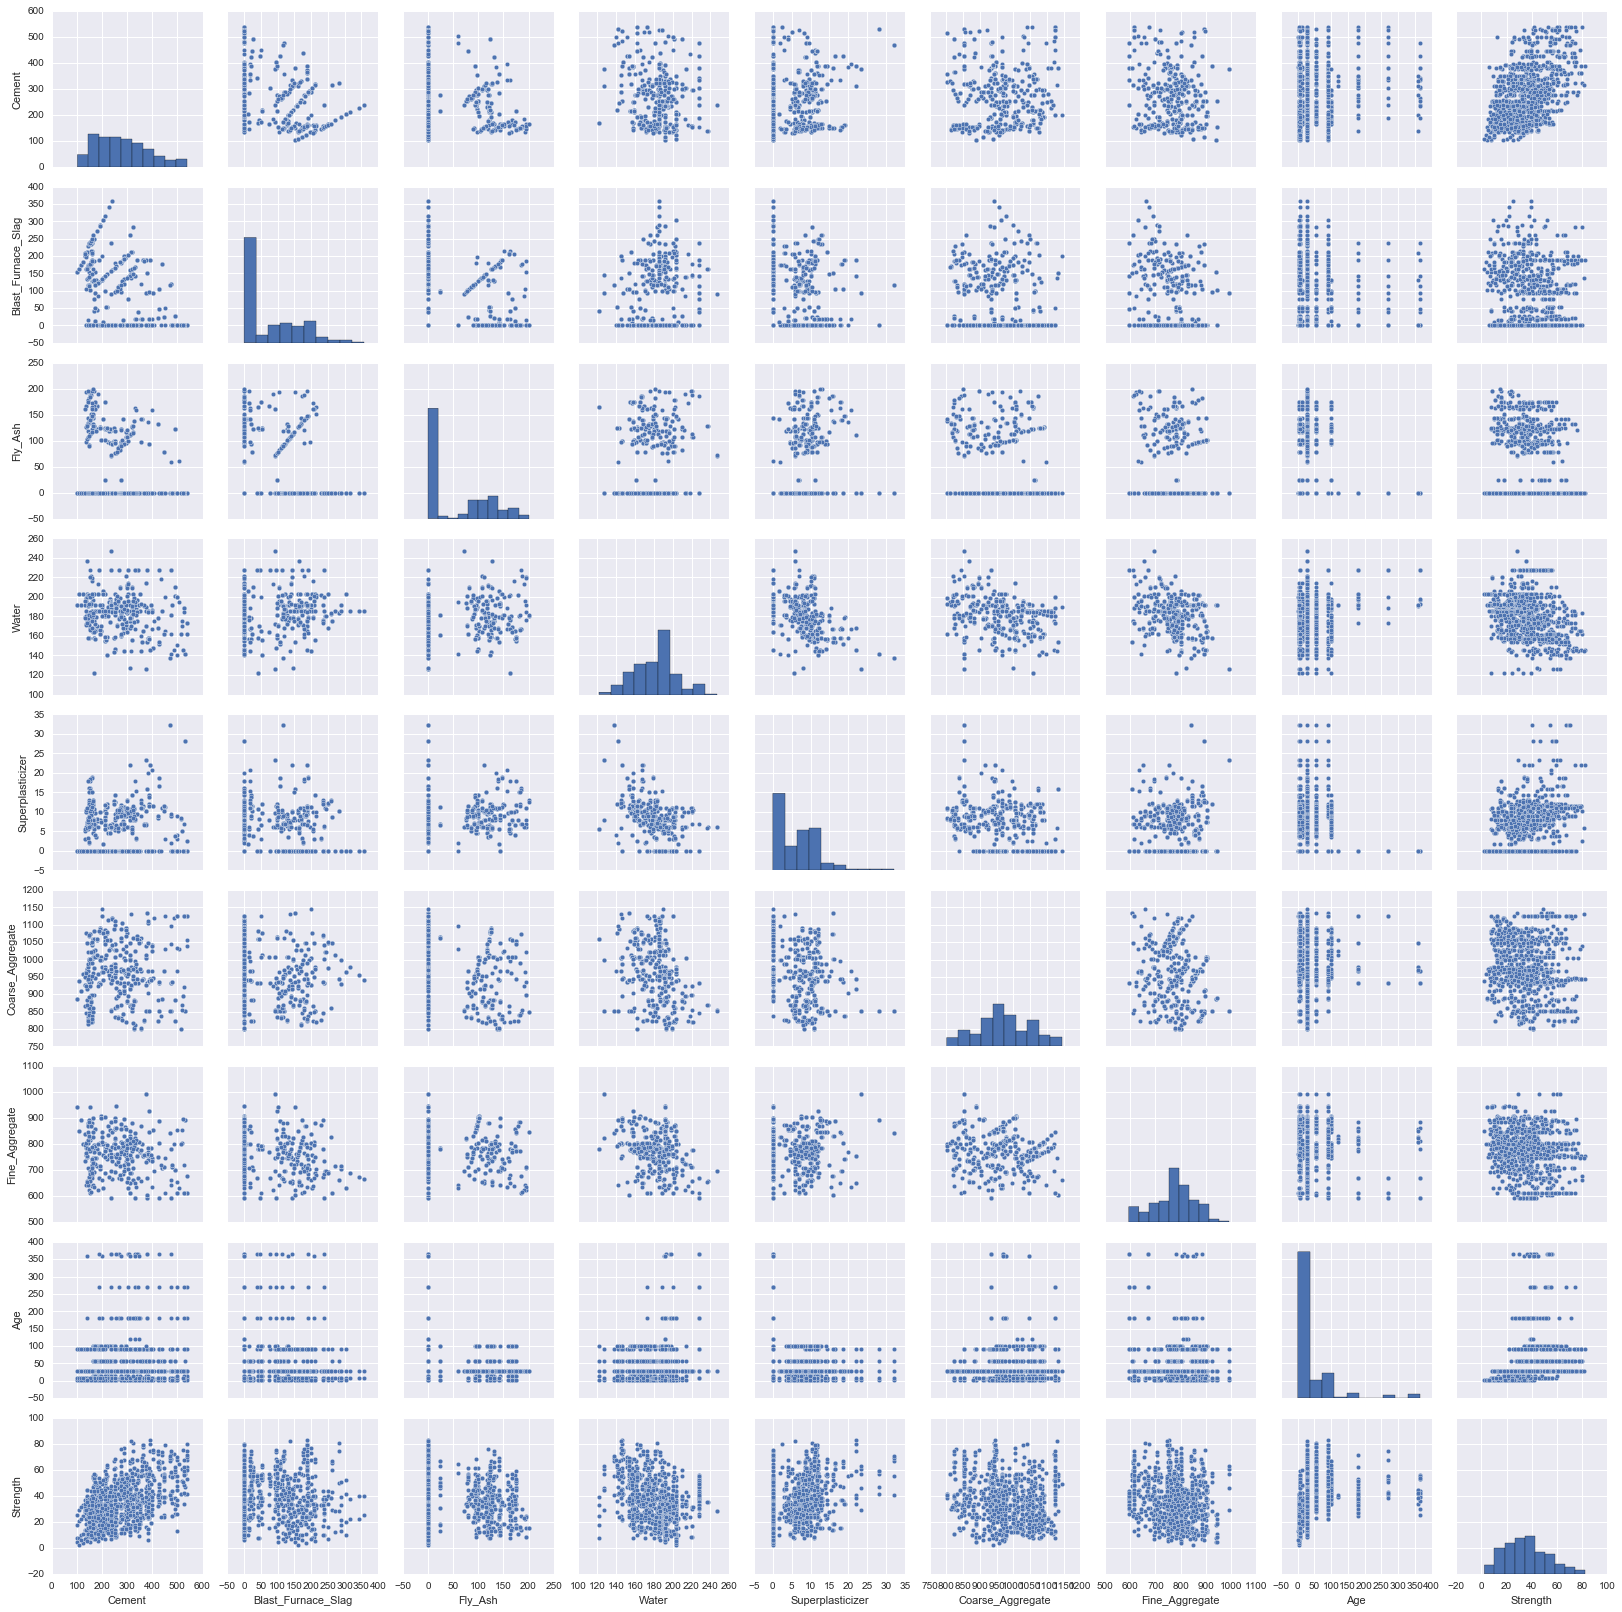

In [3]:
#-------------HW-------------------#
# Draw pairplot 
sns.pairplot(data)

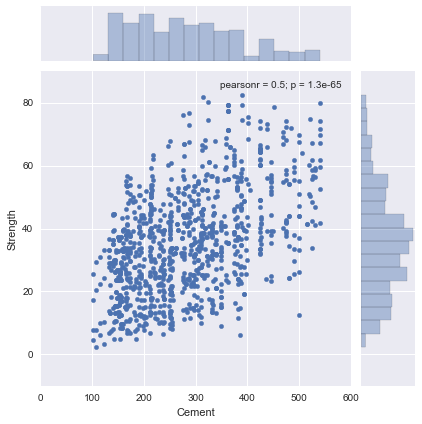

In [4]:
sns.jointplot(data['Cement'], data['Strength'])

In [5]:
colnames = data.columns.values
print(colnames)
for col in colnames[:-1] :
    p = scipy.stats.pearsonr(data[col], data[colnames[-1]])
    print("pearsonr value with {}:\t{}\t(p-value:{})".format(col, round(p[0],4), round(p[1],4)))

['Cement' 'Blast_Furnace_Slag' 'Fly_Ash' 'Water' 'Superplasticizer'
 'Coarse_Aggregate' 'Fine_Aggregate' 'Age' 'Strength']
pearsonr value with Cement:	0.4978	(p-value:0.0)
pearsonr value with Blast_Furnace_Slag:	0.1348	(p-value:0.0)
pearsonr value with Fly_Ash:	-0.1058	(p-value:0.0007)
pearsonr value with Water:	-0.2896	(p-value:0.0)
pearsonr value with Superplasticizer:	0.3661	(p-value:0.0)
pearsonr value with Coarse_Aggregate:	-0.1649	(p-value:0.0)
pearsonr value with Fine_Aggregate:	-0.1672	(p-value:0.0)
pearsonr value with Age:	0.3289	(p-value:0.0)


-0.657532907628 ('Water', 'Superplasticizer')


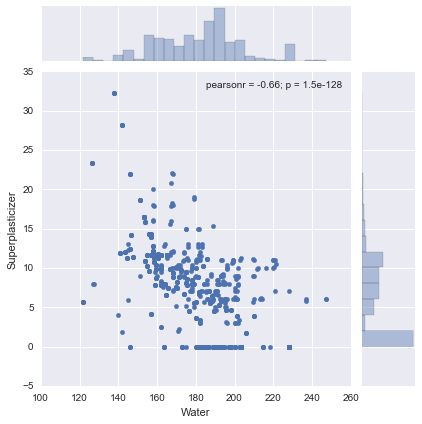

In [6]:
max_p, max_pair = 0, (None,None)
for col in colnames[:-1] :
    for col0 in colnames[list(colnames).index(col)+1:-1] :
        p, _ = scipy.stats.pearsonr(data[col], data[col0])
        if abs(max_p) < abs(p) :
            max_p, max_pair = p, (col, col0)
print(max_p, max_pair)
sns.jointplot(data[max_pair[0]], data[max_pair[1]])

### (2) 모든 설명 변수를 이용하여 강도(Strength)를 예측하는 모형을 학습하고 아래 표를 채우시오. $\alpha=0.05$일 때 0이라는 가설을 기각할 수 없는 변수는 무엇인가?

In [7]:
#-------------HW-------------------#
# apply linear regression on concrete data
# calculate standard errors, t-statistics, and p-values for estimated coeffcients

from sklearn.linear_model import LinearRegression
reg = LinearRegression()

X = data[colnames[:-1]]
y = data[colnames[-1]]

reg.fit(X, y)
print("coef:\t", reg.coef_)
print("intercept:\t", reg.intercept_)

coef:	 [ 0.11980433  0.10386581  0.08793432 -0.14991842  0.2922246   0.01808621
  0.02019035  0.11422207]
intercept:	 -23.3312135849


In [8]:
y_pred = reg.predict(X)
resid = y - y_pred
n, p = len(data), len(colnames[:-1])
SSE = sum(resid**2)
MSE = SSE/(n-p-1)

#Xmat = X.copy().values
Xmat = np.c_[np.ones(n), X]
XtX = np.matmul(Xmat.T, Xmat)
invXtX = scipy.linalg.inv(XtX)

seSqrtMat = MSE*invXtX
se_list = [seSqrtMat[j,j] for j in range(len(seSqrtMat))]
se_list = np.sqrt(se_list)
se_list

array([  2.65855040e+01,   8.48901680e-03,   1.01358018e-02,
         1.25833162e-02,   4.01770357e-02,   9.34240801e-02,
         9.39223607e-03,   1.07016850e-02,   5.42714791e-03])

In [9]:
beta_list = [reg.intercept_] + list(reg.coef_)
t_stats = np.array(beta_list)/np.array(se_list)
t_stats

array([ -0.87759155,  14.11286339,  10.24741906,   6.98816754,
        -3.7314455 ,   3.12793655,   1.9256559 ,   1.88665159,  21.04642624])

In [10]:
alpha = 0.05
t0 = scipy.stats.t.ppf(1-alpha/2, n-p-1)
is_accept, p_value = None, None # H0: \beta_i = 0
for t_stat in t_stats :
    if abs(t_stat) > t0 :
        is_accept = False
    else :
        is_accept = True
    p_value = 1-scipy.stats.t.cdf(abs(t_stat), n-p-1)
    print("{}\t{}".format(is_accept, p_value))

True	0.19018593619106317
False	0.0
False	0.0
False	2.5098811917700914e-12
False	0.00010043990925345803
False	0.0009051204388617062
True	0.02721240671866576
True	0.029745377311901078
False	0.0


### (3) 추정된 모형에 대한 ANOVA 표를 완성하시오. 전체적으로 이 모형을 강도를 예측하는데 쓸모가 있다고 할 수 있는가?

In [11]:
#-------------HW-------------------#
# calculate all values in ANOVA table
print("SSE: {}\td.f: {}\tMSE: {}".format(SSE, n-p-1, MSE))
SST = sum((y-y.mean())**2)
print("SST: {}\td.f: {}".format(SST, n-1))
SSR = SST-SSE
MSR = SSR/p
print("SSR: {}\td.f: {}\tMSR: {}".format(SSR, p, MSR))

SSE: 110413.15315710593	d.f: 1021	MSE: 108.14216763673451
SST: 287175.18711844657	d.f: 1029
SSR: 176762.03396134064	d.f: 8	MSR: 22095.25424516758


In [12]:
F0 = MSR/MSE
p_value = 1-scipy.stats.f.cdf(F0, p, n-p-1)
print("FO: {}\tp-value: {}".format(F0, p_value))

FO: 204.31673165077288	p-value: 1.1102230246251565e-16


### (4) $R^2$ 와 adjusted $R^2$ 값을 구하시오. 

In [13]:
#-------------HW-------------------#
# calculate R-squared and adjusted R-squared
R_sq = 1 - SSE/SST
adj_R_sq = 1 - (SSE/(n-p-1))/(SST/(n-1))
print("R^2: {}\tabj_R^2: {}".format(R_sq, adj_R_sq))

R^2: 0.6155198704142724	abj_R^2: 0.6125072934929345


### (5) 모든 설명 변수에 대해 개별 설명 변수를 x축으로 하고 y축을 잔차(residual)로 하는 산포도(scatter plot)을 그리시오. 산포도를 보고 알 수 있는 사항에 대해서 기술하시오. 

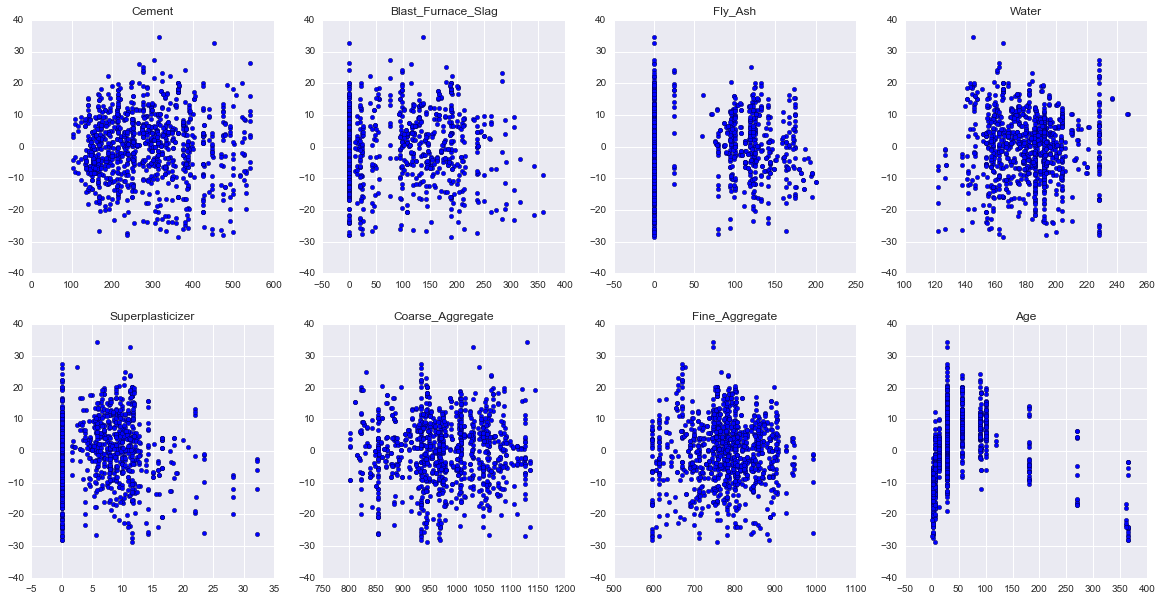

In [14]:
#-------------HW-------------------#
# draw residual plot
fig, axarr = plt.subplots(2, 4, figsize = (20,10))
i_r, i_c = 0, 0
for i in range(p) :
    col = colnames[i]
    axarr[i_r, i_c].scatter(data[col], resid)
    axarr[i_r, i_c].set_title(colnames[i])
    if i == 3 :
        i_r, i_c = 1, 0
    else :
        i_c += 1

### (6) 잔차에 대해서 Jarque-Bera test를 수행하시오. 잔차는 정규분포를 따른다고 볼 수 있는지 기술하시오. 

In [15]:
#-------------HW-------------------#
# Jarque-Bera test
S = scipy.stats.skew(resid)
C = scipy.stats.kurtosis(resid) # default: 3 뺀거
JB = (n-p)/6 * (S**2 + 1/4*C**3)
chi2_stat = scipy.stats.chi2.ppf(1-alpha, 2)
is_accept = True # H0: S = C = 0
if JB > chi2_stat :
    is_accept = False
p_value = 1 - scipy.stats.chi2.cdf(JB, 2)
print("S: {}\tC: {}\n JB: {}\tchi2_stat: {}\nH0 is accept?: {}\tp-value: {}".format(S, C, JB, chi2_stat, is_accept, p_value))

S: -0.17434637358729554	C: 0.0447840764776104
 JB: 5.181388892223999	chi2_stat: 5.99146454710798
H0 is accept?: True	p-value: 0.07496796079539081


### (7) 잔차에 대해서 Breusch-Pagan test를 수행하시오. 설명 변수에 무관하게 등분산성을 보인다고 볼 수 있는지 기술하시오. 

In [16]:
#-------------HW-------------------#
# Breusch-Pagan test
reg_bp = LinearRegression()
reg_bp.fit(X, resid**2)

LM = reg_bp.score(X,resid**2)*n
is_accept = True # H0: LM = 0 ~> F* = 0; All \gamma = 0
if LM > scipy.stats.chi2.ppf(1-alpha, p-1) :
    is_accept = False
p_value = 1 - scipy.stats.chi2.cdf(LM, p-1)
print("H0 is accept?(this means not Homoscedasticity): {}\tp-value: {}".format(is_accept, p_value))

H0 is accept?(this means not Homoscedasticity): False	p-value: 0.0


## 2. ‘Age’ 대신에 ‘Age’에 log를 취한 값을 변수로 사용하여 새로운 모형을 학습하려고 한다. 

### (1) ‘Age’와 ‘Strength’ 사이의 joint plot과 log(‘Age’)와 ‘Strength’ 사이의 joint plot을 서로 비교하고 log를 취했을 때 달라지는 점이 무엇인지 기술하시오. 

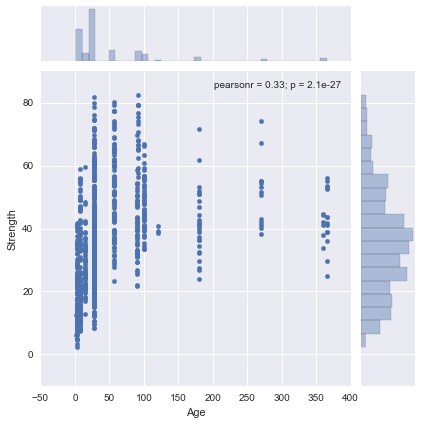

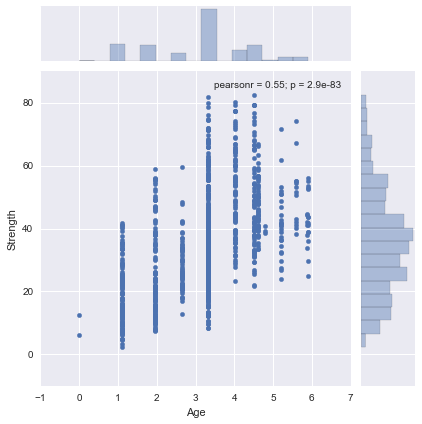

In [17]:
#-------------HW-------------------#
# Draw joint plots
sns.jointplot(data['Age'], data['Strength'])
sns.jointplot(np.log(data['Age']), data['Strength'])

### (2) 기존 변수 대신에 바뀐 변수를 포함하여 선형 회귀 모형을 학습하고 아래 표를 완성하시오.  α=0.05를 기준으로 계수가 0이라는 가설을 기각할 수 없는 변수는 무엇인가?

In [18]:
data.head(5)

,Cement,Blast_Furnace_Slag,Fly_Ash,Water,Superplasticizer,Coarse_Aggregate,Fine_Aggregate,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [19]:
newX = data[colnames[:-2]]
newX['logAge'] = np.log(data['Age'])
newX.head(5)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Cement,Blast_Furnace_Slag,Fly_Ash,Water,Superplasticizer,Coarse_Aggregate,Fine_Aggregate,logAge
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,3.332205
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,3.332205
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,5.598422
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,5.899897
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,5.886104


In [20]:
new_colnames = newX.columns
new_colnames

Index(['Cement', 'Blast_Furnace_Slag', 'Fly_Ash', 'Water', 'Superplasticizer',
       'Coarse_Aggregate', 'Fine_Aggregate', 'logAge'],
      dtype='object')

In [21]:
#-------------HW-------------------#
# apply linear regression on concrete data
# calculate standard errors, t-statistics, and p-values for estimated coeffcients
reg2 = LinearRegression()
reg2.fit(newX, y)
print("coef:\t", reg2.coef_)
print("intercept:\t", reg2.intercept_)

coef:	 [ 0.13485667  0.11594459  0.09439083 -0.12881665  0.11882222  0.02968071
  0.03598873  8.74659505]
intercept:	 -77.5333877035


In [22]:
y_pred = reg2.predict(newX)
resid = y - y_pred
n, p = len(data), len(new_colnames)
SSE = sum(resid**2)
MSE = SSE/(n-p-1)

#Xmat = X.copy().values
Xmat = np.c_[np.ones(n), newX]
XtX = np.matmul(Xmat.T, Xmat)
invXtX = scipy.linalg.inv(XtX)

seSqrtMat = MSE*invXtX
se_list = [seSqrtMat[j,j] for j in range(len(seSqrtMat))]
se_list = np.sqrt(se_list)
se_list

array([  1.83307998e+01,   5.84930154e-03,   6.96491104e-03,
         8.62471997e-03,   2.75641947e-02,   6.43661039e-02,
         6.46209065e-03,   7.36588931e-03,   1.91767646e-01])

In [23]:
beta_list = [reg2.intercept_] + list(reg2.coef_)
t_stats = np.array(beta_list)/np.array(se_list)
t_stats

array([ -4.22967839,  23.05517422,  16.64695891,  10.94422009,
        -4.67333262,   1.84603716,   4.59305014,   4.88586294,  45.61037923])

In [24]:
alpha = 0.05
t0 = scipy.stats.t.ppf(1-alpha/2, n-p-1)
is_accept, p_value = None, None # H0: \beta_i = 0
for t_stat in t_stats :
    if abs(t_stat) > t0 :
        is_accept = False
    else :
        is_accept = True
    p_value = 1-scipy.stats.t.cdf(abs(t_stat), n-p-1)
    print("{}\t{}".format(is_accept, p_value))

False	1.275191139438192e-05
False	0.0
False	0.0
False	0.0
False	1.6799889313023897e-06
True	0.03258806703970607
False	2.456492055880055e-06
False	5.97474268282383e-07
False	0.0


### (3) 추정된 모형에 대한 ANOVA 표를 완성하시오. 전체적으로 이 모형을 강도를 예측하는데 쓸모가 있다고 할 수 있는가?

In [25]:
#-------------HW-------------------#
# calculate all values in ANOVA table
print("SSE: {}\td.f: {}\tMSE: {}".format(SSE, n-p-1, MSE))
SST = sum((y-y.mean())**2)
print("SST: {}\td.f: {}".format(SST, n-1))
SSR = SST-SSE
MSR = SSR/p
print("SSR: {}\td.f: {}\tMSR: {}".format(SSR, p, MSR))

SSE: 52119.82519361702	d.f: 1021	MSE: 51.0478209535916
SST: 287175.18711844657	d.f: 1029
SSR: 235055.36192482954	d.f: 8	MSR: 29381.920240603693


In [26]:
F0 = MSR/MSE
p_value = 1-scipy.stats.f.cdf(F0, p, n-p-1)
print("FO: {}\tp-value: {}".format(F0, p_value))

FO: 575.5763848826235	p-value: 1.1102230246251565e-16


### (4) $R^2$ 와 adjusted $R^2$ 값을 구하시오. 기존 것과 비교했을 때 어느 쪽이 다 낫다고 볼 수 있는가?

In [27]:
#-------------HW-------------------#
# calculate R-squared and adjusted R-squared
print("R^2: {}\tabj_R^2: {}".format(R_sq, adj_R_sq))
R_sq = 1 - SSE/SST
adj_R_sq = 1 - (SSE/(n-p-1))/(SST/(n-1))
print("R^2: {}\tabj_R^2: {}".format(R_sq, adj_R_sq))

R^2: 0.6155198704142724	abj_R^2: 0.6125072934929345
R^2: 0.818508605438394	abj_R^2: 0.8170865377043168


### (5) 모든 설명 변수에 대해 개별 설명 변수를 x축으로 하고 y축을 잔차(residual)로 하는 산포도(scatter plot)을 그리시오. 산포도를 보고 변화한 사항에 대해 기술하시오. 

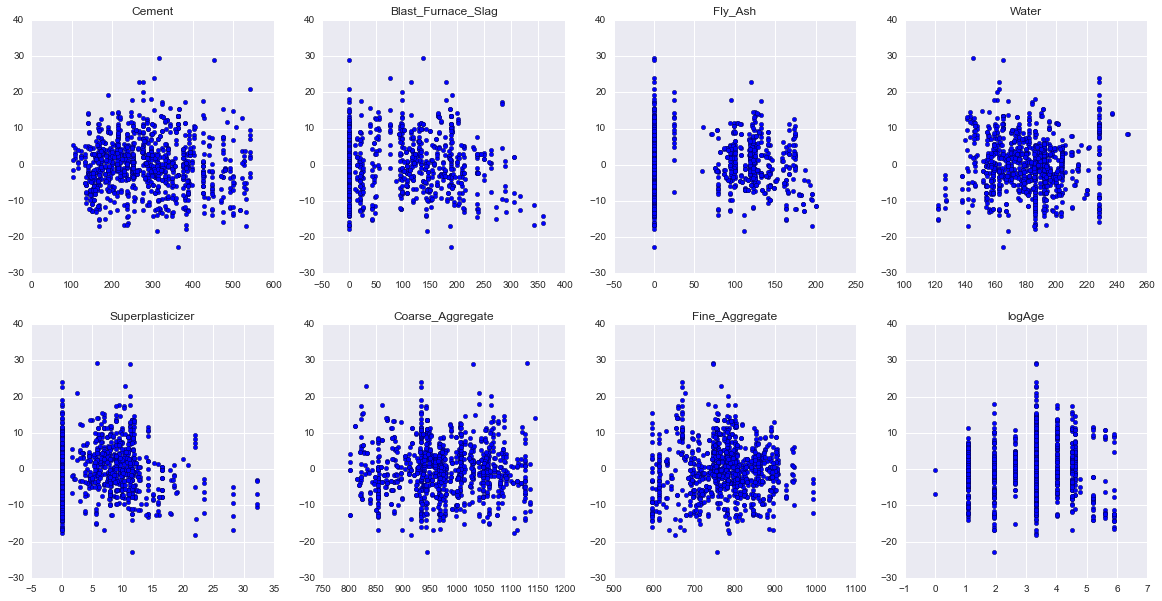

In [28]:
#-------------HW-------------------#
# draw residual plot
fig, axarr = plt.subplots(2, 4, figsize = (20,10))
i_r, i_c = 0, 0
for i in range(p) :
    col = new_colnames[i]
    axarr[i_r, i_c].scatter(newX[col], resid)
    axarr[i_r, i_c].set_title(new_colnames[i])
    if i == 3 :
        i_r, i_c = 1, 0
    else :
        i_c += 1

### (6) 잔차에 대해서 Jarque-Bera test를 수행하시오. 잔차는 정규분포를 따른다고 볼 수 있는지 기술하시오.

In [29]:
#-------------HW-------------------#
# Jarque-Bera test
S = scipy.stats.skew(resid)
C = scipy.stats.kurtosis(resid) # default: 3 뺀거
JB = (n-p)/6 * (S**2 + 1/4*C**3)
chi2_stat = scipy.stats.chi2.ppf(1-alpha, 2)
is_accept = True # H0: S = C = 0
if JB > chi2_stat :
    is_accept = False
p_value = 1 - scipy.stats.chi2.cdf(JB, 2)
print("S: {}\tC: {}\n JB: {}\tchi2_stat: {}\nH0 is accept?: {}\tp-value: {}".format(S, C, JB, chi2_stat, is_accept, p_value))

S: 0.26638336768429105	C: 0.496063145581378
 JB: 17.285040892275216	chi2_stat: 5.99146454710798
H0 is accept?: False	p-value: 0.0001764416297114213


### (7) 잔차에 대해서 Breusch-Pagan test를 수행하시오. 설명 변수에 무관하게 등분산성을 보인다고 볼 수 있는지 기술하시오.

In [30]:
#-------------HW-------------------#
# Breusch-Pagan test
reg2_bp = LinearRegression()
reg2_bp.fit(newX, resid**2)

LM = reg2_bp.score(newX,resid**2)*n
is_accept = True # H0: LM = 0 ~> F* = 0; All \gamma = 0
if LM > scipy.stats.chi2.ppf(1-alpha, p-1) :
    is_accept = False
p_value = 1 - scipy.stats.chi2.cdf(LM, p-1)
print("H0 is accept?(this means not Homoscedasticity): {}\tp-value: {}".format(is_accept, p_value))

H0 is accept?(this means not Homoscedasticity): False	p-value: 0.0
